In [1]:
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import ortho_group

import torch
import torch.nn as nn
import torchvision

In [2]:
########### Set Device ############
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda:0


In [3]:
class AddNoise(nn.Module):
    def __init__(self, scale=0.05, device=device):
        super(AddNoise, self).__init__()
        self.scale = scale
        self.device = device
    
    def forward(self, x):
        return x + self.scale * torch.randn(x.shape).to(self.device)


class NoisyLinear(nn.Linear):
    def __init__(self, *args, scale=0.05, device=device, **kwargs):
        super(NoisyLinear, self).__init__(*args, **kwargs)
        self.scale = scale
        self.device = device
    
    def forward(self, x):
        weight_noise = self.scale * torch.randn(self.weight.shape).to(self.device)
        bias_noise = self.scale * torch.randn(self.bias.shape).to(self.device)
        return nn.functional.linear(x, self.weight + weight_noise, self.bias + bias_noise)

In [4]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)




/home/eric/miniconda3/envs/entropy/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    with torch.no_grad():
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, loss_fn, dataset, device, N=2000, batch_size=50):
    with torch.no_grad():
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            loss += loss_fn(logits, labels.to(device))
            total += x.size(0)
        return (loss / total).item()

In [6]:
scales = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.07, 0.1, 0.14, 0.17, 0.2, 0.3, 0.5]

In [7]:
data = dict()

In [8]:
epochs = 20

for scale in tqdm(scales):
    network = nn.Sequential(
        nn.Flatten(),
        AddNoise(scale=scale),
        NoisyLinear(28*28, 300, scale=scale),
        nn.ReLU(),
        NoisyLinear(300, 100, scale=scale),
        nn.ReLU(),
        NoisyLinear(100, 10, scale=scale),
        AddNoise(scale=scale)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters())
    network.train()
    
    batches = []
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    batch_n = 0
    for epoch in tqdm(range(epochs), leave=False):
        network.train()
        for x, label in train_loader:
            
            if batch_n % 200 == 0:
                with torch.no_grad():
                    batches.append(batch_n)
                    train_losses.append(compute_loss(network, loss_fn, train, device))
                    test_losses.append(compute_loss(network, loss_fn, test, device))
                    train_accuracies.append(compute_accuracy(network, train, device))
                    test_accuracies.append(compute_accuracy(network, test, device))
                    
            optimizer.zero_grad()
            loss = loss_fn(network(x.to(device)), label.to(device))
            loss.backward()
            optimizer.step()
            batch_n += 1
    
    results = dict()
    results['batches'] = batches
    results['train_losses'] = train_losses
    results['test_losses'] = test_losses
    results['train_accuracies'] = train_accuracies
    results['test_accuracies'] = test_accuracies
    data[scale] = results


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
# import pickle
# with open("machine-precision-runs-data.pkl", "wb") as f:
#     pickle.dump(data, f)


In [36]:
with open("machine-precision-runs-data.pkl", "rb") as f:
    data = pickle.load(f)

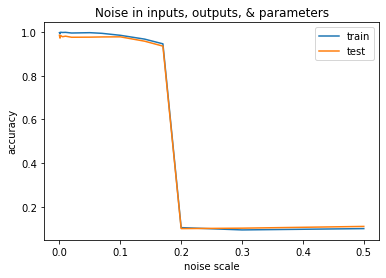

In [40]:
final_train_accuracies = [data[scale]['train_accuracies'][-1] for scale in scales]
final_test_accuracies = [data[scale]['test_accuracies'][-1] for scale in scales]
plt.plot(scales, final_train_accuracies, label="train")
plt.plot(scales, final_test_accuracies, label="test")
plt.ylabel("accuracy")
plt.xlabel("noise scale")
plt.title("Noise in inputs, outputs, & parameters")
# plt.xscale('log')
plt.legend()

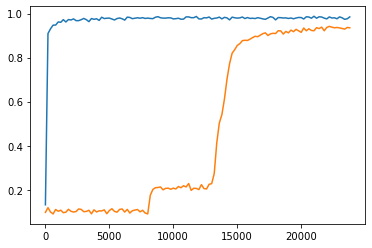

In [23]:
plt.plot(data[0.0]['batches'], data[0.0]['test_accuracies'])
plt.plot(data[0.17]['batches'], data[0.17]['test_accuracies'])

Text(0.5, 0, 'noise scale')

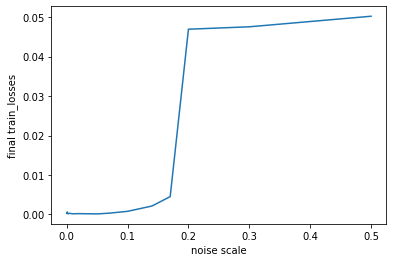

In [12]:
metric = []
for scale in scales:
    metric.append(data[scale]['train_losses'][-1])
plt.plot(scales, metric)
plt.ylabel("final train_losses")
plt.xlabel("noise scale")
# plt.xscale('log')

In [28]:
epochs = 20

for scale in tqdm(scales):
    network = nn.Sequential(
        nn.Flatten(),
        AddNoise(scale=scale),
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
        AddNoise(scale=scale)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters())
    network.train()
    
    batches = []
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    batch_n = 0
    for epoch in tqdm(range(epochs), leave=False):
        network.train()
        for x, label in train_loader:
            
            if batch_n % 200 == 0:
                with torch.no_grad():
                    batches.append(batch_n)
                    train_losses.append(compute_loss(network, loss_fn, train, device))
                    test_losses.append(compute_loss(network, loss_fn, test, device))
                    train_accuracies.append(compute_accuracy(network, train, device))
                    test_accuracies.append(compute_accuracy(network, test, device))
                    
            optimizer.zero_grad()
            loss = loss_fn(network(x.to(device)), label.to(device))
            loss.backward()
            optimizer.step()
            batch_n += 1
    
    results = dict()
    results['batches'] = batches
    results['train_losses'] = train_losses
    results['test_losses'] = test_losses
    results['train_accuracies'] = train_accuracies
    results['test_accuracies'] = test_accuracies
    data[scale] = results


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
# import pickle
# with open("machine-precision-input-output-runs-data.pkl", "wb") as f:
#     pickle.dump(data, f)


In [41]:
with open("machine-precision-input-output-runs-data.pkl", "rb") as f:
    data = pickle.load(f)

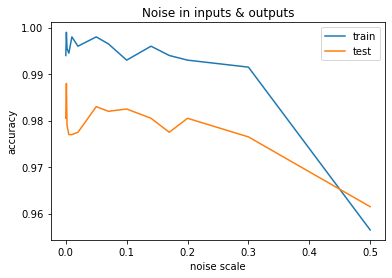

In [42]:
final_train_accuracies = [data[scale]['train_accuracies'][-1] for scale in scales]
final_test_accuracies = [data[scale]['test_accuracies'][-1] for scale in scales]
plt.plot(scales, final_train_accuracies, label="train")
plt.plot(scales, final_test_accuracies, label="test")
plt.ylabel("accuracy")
plt.xlabel("noise scale")
plt.title("Noise in inputs & outputs")
# plt.xscale('log')
plt.legend()

In [31]:
data = dict()

In [32]:
epochs = 20

for scale in tqdm(scales):
    network = nn.Sequential(
        nn.Flatten(),
        NoisyLinear(28*28, 300, scale=scale),
        nn.ReLU(),
        NoisyLinear(300, 100, scale=scale),
        nn.ReLU(),
        NoisyLinear(100, 10, scale=scale),
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters())
    network.train()
    
    batches = []
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    batch_n = 0
    for epoch in tqdm(range(epochs), leave=False):
        network.train()
        for x, label in train_loader:
            
            if batch_n % 200 == 0:
                with torch.no_grad():
                    batches.append(batch_n)
                    train_losses.append(compute_loss(network, loss_fn, train, device))
                    test_losses.append(compute_loss(network, loss_fn, test, device))
                    train_accuracies.append(compute_accuracy(network, train, device))
                    test_accuracies.append(compute_accuracy(network, test, device))
                    
            optimizer.zero_grad()
            loss = loss_fn(network(x.to(device)), label.to(device))
            loss.backward()
            optimizer.step()
            batch_n += 1
    
    results = dict()
    results['batches'] = batches
    results['train_losses'] = train_losses
    results['test_losses'] = test_losses
    results['train_accuracies'] = train_accuracies
    results['test_accuracies'] = test_accuracies
    data[scale] = results


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [33]:
# import pickle
# with open("machine-precision-only-weights-runs-data.pkl", "wb") as f:
#     pickle.dump(data, f)


In [43]:
with open("machine-precision-only-weights-runs-data.pkl", "rb") as f:
    data = pickle.load(f)

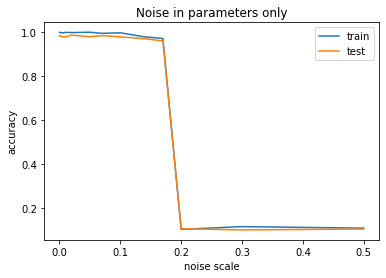

In [44]:
final_train_accuracies = [data[scale]['train_accuracies'][-1] for scale in scales]
final_test_accuracies = [data[scale]['test_accuracies'][-1] for scale in scales]
plt.plot(scales, final_train_accuracies, label="train")
plt.plot(scales, final_test_accuracies, label="test")
plt.ylabel("accuracy")
plt.xlabel("noise scale")
plt.title("Noise in parameters only")
# plt.xscale('log')
plt.legend()